# 0 Ray Serve Overview

## 0.1 Architecture

### 0.1.1 Ray Overall Architecture

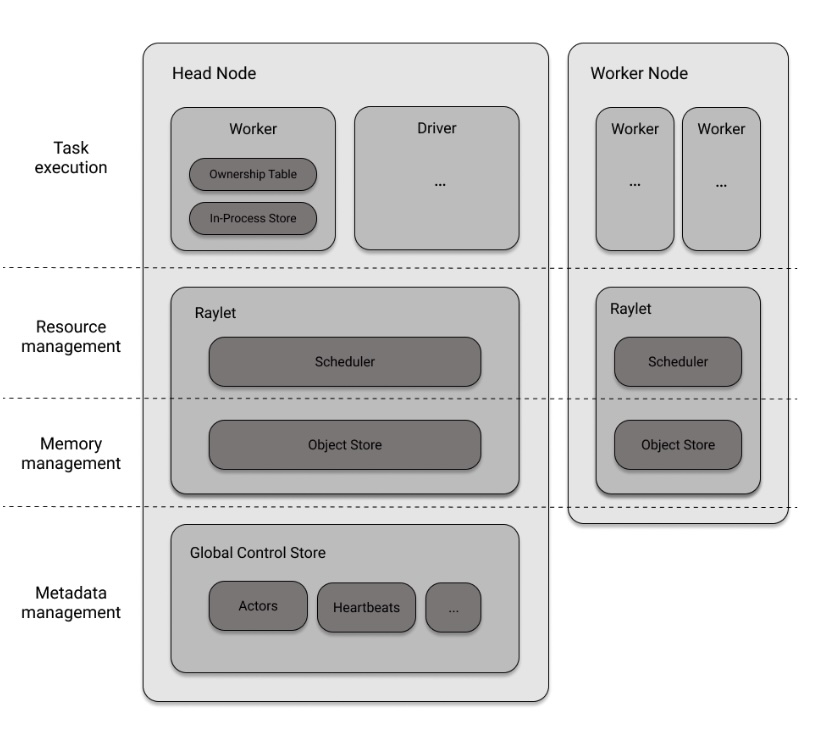

- **Head Node**:
  - The central node in a Ray cluster responsible for orchestrating operations. 
  - Manages task scheduling, monitors resource usage, and ensures fault tolerance by redistributing tasks from failed nodes to healthy ones.
- **Worker Nodes**:
  - Nodes in the Ray cluster that execute tasks and actors
  - They register with the Head Node and communicate with the Global Control Store to receive instructions and report their status.
- **Ray Tasks**:
  - Functions decorated with `@ray.remote` that execute asynchronously in separate processes, potentially across different machines.
  - Enables parallel execution and efficient resource utilization.
- **Raylets**
    - Reside on each node 
    - _Object Store_: 
      - A shared memory space where tasks can store and retrieve objects efficiently. 
      - Facilitates fast data sharing between tasks without serialization and deserialization overhead.
    - _Scheduler_: 
      - Ray's scheduler dynamically assigns tasks to available resources, optimizing for load balancing and locality. 
      - Efficiently handles task dependencies and ensures correct task execution order.
-  **Ray Actors**:
     - Stateful workers that maintain state across multiple method invocations.
     - Useful for scenarios requiring state persistence, such as managing counters or maintaining model parameters in ML applications.
     - _Actors_ for distributed computing are not a new concept. Other implementation exist such as Akka in Scala and Erlang.
- **Fault Tolerance and Ownership**: 
  - Ray employs an ownership model where the task or actor that creates an object becomes its owner. 
  - In case of failures, Ray can recover by rescheduling tasks and reconstructing lost objects based on lineage information.
- **Distributed Scheduling and Execution**: 
  - Supports distributed scheduling by allowing tasks to spawn other tasks, enabling dynamic and recursive parallelism. 
  - Useful for complex workloads like parallel tree search or dynamic programming.




**Note** : Above Info and Diagram has been adapted from https://maxpumperla.com/learning_ray/ch_02_ray_core/

### 0.1.2 Ray Serve Architecture

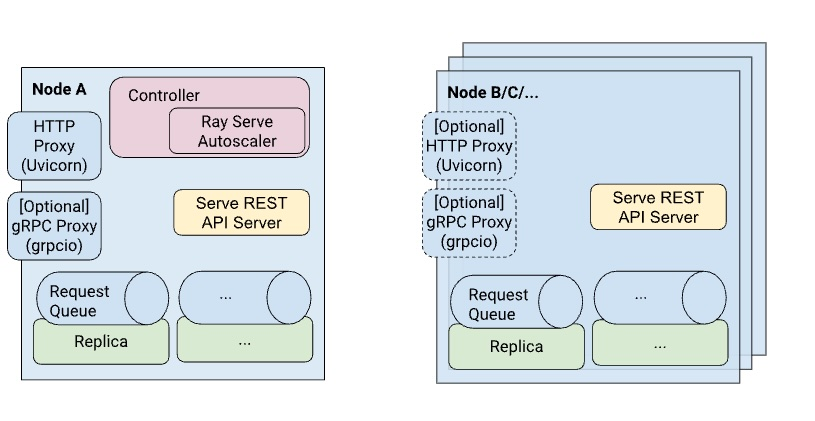

**Compoonents**

This builds upon top of Ray Actors. Three kinds of actors make up a serve instance a.k.a as deployment

- _Controller_
    - A global actor that manages the control plane, handling deployment creation, updates, and deletion.
- _Router_
    - A per-node actor running a Uvicorn HTTP server and/or gRPC proxy to forward incoming requests to worker replicas.
- _Replica_
    - An actor that executes user-defined code in response to requests from routers.

**Lifecyle**

- _Request Handling_: Incoming HTTP or gRPC requests are received, parsed, and mapped to the correct deployment.
- _Queue & Execution_: Requests are queued and sent to an available replica; if none are available, they wait in the queue.
- _Processing_: Replicas process requests sequentially or asynchronously, with async handlers running without blocking.


**Fault tolerance**

- _Application Errors_: Exceptions in model evaluation are caught, returning a 500 status code while allowing replicas to continue handling requests.
- _Actor Failures_: The Controller automatically replaces failed replicas, restarts proxies, and is itself restarted by Ray if it fails.
- _Machine & Cluster Failures_: Crashed actors are restarted on available machines, with critical data checkpointed in the Ray Global Control Store (GCS), though transient data is lost.

 
**Note** : Above Info and Diagram has been adapted from https://docs.ray.io/en/latest/serve/architecture.html

# 1. Set up environment

## 1.1 Install a Virtual env with all dependencies

### 1.1.1 UV Based Environment Creation
- Running below cell  requires uv to be installed on your machine. 
- You can install from https://docs.astral.sh/uv/pip/environments/
- If you dont want UV please use pip based install

In [ ]:
%%bash
uv venv ray_env
source ray_env/bin/activate
uv pip install ipykernel nbconvert
uv pip install ray[serve] nest-asyncio litellm
python -m ipykernel install --user --name=ray_env


### 1.1.2 PIP Based Environment Creation
 - Uncomment below a dn run if you do want to not use above uv base install

In [ ]:
# %%bash
# python -m pip install --user virtualenv
# python -m virtualenv ray_env
# source ray_env/bin/activate
# python -m pip install ipykernel nbconvert
# python -m pip install ray[serve] nest-asyncio litellm
# python -m ipykernel install --user --name=ray_env

## 1.2 Activate the Kernel
- refresh the browser
- activate the _guarded_llm_env_ kernel

# 2. Simple LLM Chat_Completions Endpoint

## 2.1 Set up your LLM Provider and Authentication token


In [1]:
import os
os.environ["LLM_API_TOKEN"] = ""


In [2]:
import os
LLM_PROVIDER_BASE="https://api.openai.com/v1"
LLM_API_TOKEN=os.environ["LLM_API_TOKEN"] 

## 2.2 Create a simple FastAPI endpoint which can interact with an OPEN AI compliant end point
- I am using litellm completion method here
- Reference : https://docs.litellm.ai/docs/completion/input

In [3]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import litellm
import os

app = FastAPI()


class ChatRequest(BaseModel):
    model: str = "gpt-3.5-turbo"  # Default model
    prompt: str
    temperature: float = 0.7
    max_tokens: int = 256


@app.post("/chat/")
async def chat(request: ChatRequest):
    try:
        # Call OpenAI using litellm
        response = litellm.completion(
            api_base=LLM_PROVIDER_BASE,
            api_key=LLM_API_TOKEN,
            model=request.model,
            messages=[{"role": "user", "content": request.prompt}],
            temperature=request.temperature,
            max_tokens=request.max_tokens,
        )

        return {"response": response["choices"][0]["message"]["content"]}

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))



### 2.3 Serve the Fast API end point
  - I am using an asyncio loop to serve the app in an async way from notebook

In [4]:
import asyncio
import uvicorn

if __name__ == "__main__":
    config = uvicorn.Config(app, host="0.0.0.0", port=9000)
    server = uvicorn.Server(config)
    loop = asyncio.get_running_loop()
    loop.create_task(server.serve())

INFO:     Started server process [108]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:9000 (Press CTRL+C to quit)


INFO:     172.18.0.1:59974 - "GET /docs HTTP/1.1" 200 OK
INFO:     172.18.0.1:59974 - "GET /openapi.json HTTP/1.1" 200 OK


# 3. Deploy Fast API app Using Ray Serve

## 3.1 Write a Ray Wrapper

In [5]:
from ray import serve

@serve.deployment
@serve.ingress(app)
class RayApp:
    pass


rayapp = RayApp.bind()

/ray_serve_tutorial/notebooks/ray_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-03 23:38:53,972	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## 3.2 Another ray app with config data

In [6]:
from ray import serve



@serve.deployment(num_replicas=2, ray_actor_options={"num_cpus": 2})
@serve.ingress(app)
class RayAppAdvanced:
    pass


rayappadvanced = RayAppAdvanced.bind()

## 3.3 Deploy on a  ray serve cluster

### 3.3.1 Start a simple Ray Serve Cluster

In [7]:
%%bash
source ray_env/bin/activate
ray start --head --dashboard-host 0.0.0.0

2025-04-03 23:39:18,535	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.09gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


2025-04-03 23:39:17,094	INFO usage_lib.py:467 -- Usage stats collection is enabled by default without user confirmation because this terminal is detected to be non-interactive. To disable this, add `--disable-usage-stats` to the command that starts the cluster, or run the following command: `ray disable-usage-stats` before starting the cluster. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.
2025-04-03 23:39:17,094	INFO scripts.py:861 -- Local node IP: 172.18.0.2
2025-04-03 23:39:19,684	SUCC scripts.py:897 -- --------------------
2025-04-03 23:39:19,684	SUCC scripts.py:898 -- Ray runtime started.
2025-04-03 23:39:19,684	SUCC scripts.py:899 -- --------------------
2025-04-03 23:39:19,684	INFO scripts.py:901 -- Next steps
2025-04-03 23:39:19,684	INFO scripts.py:904 -- To add another node to this Ray cluster, run
2025-04-03 23:39:19,684	INFO scripts.py:907 --   ray start --address='172.18.0.2:6379'
2025-04-03 23:39:19,684	INFO scripts.py:916 -- To connect to t

### 3.3.2 Deploy above Ray Wrapped Fast API app on Ray Serve

In [8]:
import time
time.sleep(15)
serve.run(rayapp, name="fastapiappponray")


2025-04-03 23:40:04,620	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 172.18.0.2:6379...
2025-04-03 23:40:04,633	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at http://172.18.0.2:8265 
(ProxyActor pid=468) INFO 2025-04-03 23:40:05,248 proxy 172.18.0.2 -- Proxy starting on node fb32be7170989b4bda790af84c50c5299e7af815b189a137880d6424 (HTTP port: 8000).
(ProxyActor pid=468) INFO 2025-04-03 23:40:05,262 proxy 172.18.0.2 -- Got updated endpoints: {}.
INFO 2025-04-03 23:40:05,285 serve 108 -- Started Serve in namespace "serve".
(ServeController pid=469) INFO 2025-04-03 23:40:05,298 controller 469 -- Deploying new version of Deployment(name='RayApp', app='fastapiappponray') (initial target replicas: 1).
(ProxyActor pid=468) INFO 2025-04-03 23:40:05,299 proxy 172.18.0.2 -- Got updated endpoints: {Deployment(name='RayApp', app='fastapiappponray'): EndpointInfo(route='/', app_is_cross_language=False)}.
(ProxyActor pid=468) INFO 2025-04-03 23:40:05,

DeploymentHandle(deployment='RayApp')

(ServeController pid=469) INFO 2025-04-03 23:40:50,251 controller 469 -- Deploying new version of Deployment(name='RayAppAdvanced', app='fastapiappponrayadv') (initial target replicas: 2).
(ProxyActor pid=468) INFO 2025-04-03 23:40:50,254 proxy 172.18.0.2 -- Got updated endpoints: {Deployment(name='RayApp', app='fastapiappponray'): EndpointInfo(route='/', app_is_cross_language=False), Deployment(name='RayAppAdvanced', app='fastapiappponrayadv'): EndpointInfo(route='/parameterized_app', app_is_cross_language=False)}.
(ServeController pid=469) INFO 2025-04-03 23:40:50,356 controller 469 -- Adding 2 replicas to Deployment(name='RayAppAdvanced', app='fastapiappponrayadv').


In [9]:
serve.run(rayappadvanced, name="fastapiappponrayadv", route_prefix="/parameterized_app")

INFO 2025-04-03 23:40:50,237 serve 108 -- Connecting to existing Serve app in namespace "serve". New http options will not be applied.
INFO 2025-04-03 23:40:52,355 serve 108 -- Application 'fastapiappponrayadv' is ready at http://127.0.0.1:8000/parameterized_app.


DeploymentHandle(deployment='RayAppAdvanced')